# Inversion of Time Domain EM data: Bookpurnong Australia

This example is based on the inversion published of SkyTEM data over Bookpurnong in [Heagy et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0098300416303946)


In [1]:
# core python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
from scipy.constants import mu_0

# SimPEG and related packages
from pymatsolver import Pardiso as Solver
from SimPEG import (
    Mesh, Maps, Utils, DataMisfit, Regularization, Optimization, 
    Inversion, InvProblem, Directives
)
from SimPEG.EM import TDEM

In [2]:
# larger font size for plots
from matplotlib import rcParams
rcParams['font.size']=14

## Look at the contents of the data directory we are given

In [3]:
data_directory = os.path.sep.join(["..", "data", "bookpurnong"])
os.listdir(data_directory)

['8044_Bookpurnong(1).HDR',
 '8044_Bookpurnong.HDR',
 'Bookpurnong_Resolve_Exported(1).XYZ',
 'Bookpurnong_Resolve_Exported.XYZ',
 'Bookpurnong_SkyTEM(1).HDR',
 'Bookpurnong_SkyTEM.HDR',
 'MurrayRiver(1).txt',
 'MurrayRiver.txt',
 'README(1).txt',
 'README.txt',
 'SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM(1).txt',
 'SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt']

### look at the README for a description of the files

In [4]:
# the os.path.sep.join combines the "bookpurnong" and "README.txt" with the 
# correct path seperator (e.g. on mac or linux, this will produce 
# "bookpurnong/README.txt")

with open(os.path.sep.join([data_directory, "README.txt"]), 'r') as file:
    print(file.read())

Bookpurnong Data Sets

The RESOLVE and SkyTEM data collected over Bookpurnong have been made available with permission from CSIRO. Please acknowledge CSIRO if using these data in a presentation, publication, etc.

Two data sets are included in this distribution, RESOLVE data collected in 2008, and SkyTEM (High Moment) data collected in 2006.

For an example of how to load and plot the data, please see: http://docs.simpeg.xyz


Contents
--------

- 8044_Bookpurnong.HDR : RESOLVE header file for the 2008 Bookpurnong survey
- Bookpurnong_Resolve_Exported.XYZ : RESOLVE data collected in 2008
- Bookpurnong_SkyTEM.HDR : SkyTEM header file for the 2006 Bookpurnong survey
- SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt : SkyTEM high moment data collected in 2006






### Load the SkyTEM data

Here, we use the [pandas](https://pandas.pydata.org/) library to read in the data. Pandas is good for working with tabular data, particularly when those data might not all be of the same type. For example, in the SkyTEM data set, there are dates, numeric values, times, ... These don't nicely fit into a numpy array, but do fit nicely into a pandas data frame. 

In [5]:
# Load SkyTEM 2005
skytem = pd.read_table(
    os.path.sep.join([data_directory, "SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt"])
)

list(skytem)  # list the data header

['FID',
 'LINE',
 'Date',
 'TimeBegin',
 'Date.1',
 'TimeEnd',
 'DateTime',
 'Stack',
 'AngleX',
 'AngleY',
 'LASALT',
 'Current',
 'N',
 'E',
 'GPSALT',
 'DTMLEV',
 'GdSpeed',
 'Z_Ch7',
 'Z_Ch8',
 'Z_Ch9',
 'Z_Ch10',
 'Z_Ch11',
 'Z_Ch12',
 'Z_Ch13',
 'Z_Ch14',
 'Z_Ch15',
 'Z_Ch16',
 'Z_Ch17',
 'Z_Ch18',
 'Z_Ch19',
 'Z_Ch20',
 'Z_Ch21',
 'Z_Ch22',
 'Z_Ch23',
 'Z_Ch24',
 'Z_Ch25',
 'Z_Ch26',
 'Z_Ch27',
 'Z_Ch28',
 'Z_Ch29',
 'Z_Ch30',
 'X_CH7',
 'X_CH8',
 'X_CH9',
 'X_CH10',
 'X_CH11',
 'X_CH12',
 'X_CH13',
 'X_CH14',
 'X_CH15',
 'X_CH16',
 'X_CH17',
 'X_CH18',
 'X_CH19',
 'X_CH20',
 'X_CH21',
 'X_CH22',
 'X_CH23',
 'X_CH24',
 'X_CH25',
 'X_CH26',
 'X_CH27',
 'X_CH28',
 'X_CH29',
 'X_CH30']

In [6]:
# pull out the flight lines
lines = np.unique(skytem.LINE)

In [7]:
skytem.LINE

0       21001
1       21001
2       21001
3       21001
4       21001
        ...  
5606     2004
5607     2004
5608     2004
5609     2004
5610     2004
Name: LINE, Length: 5611, dtype: int64

In [8]:
# Load path of Murray River
river_path = np.loadtxt(os.path.sep.join([data_directory, "MurrayRiver.txt"]))

In [9]:
def plot_line(line_number, ax=None):
    """
    A plotting function that will plot all sounding locations for a given `line_number`
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    inds = skytem.LINE == line_number
    ax.plot(skytem.E[inds], skytem.N[inds], '.', ms=0.6)
    return ax

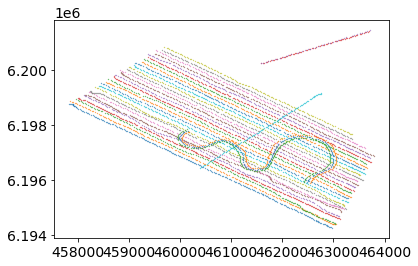

In [10]:
# plot all of the flight lines
fig, ax = plt.subplots(1, 1)
for l in lines:
    plot_line(l, ax=ax)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

Find and omit the tie lines and lines along river. 

Here, I use a small widget to plot line by line to see which lines are the ones that are along the river or are tie lines. 

In [11]:
ipywidgets.interactive(
    lambda ind: plot_line(lines[ind]), 
    ind=ipywidgets.IntSlider(min=0, max=len(lines)-1, value=0),
)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

interactive(children=(IntSlider(value=0, description='ind', max=34), Output()), _dom_classes=('widget-interact…

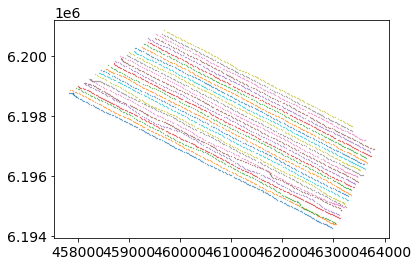

In [12]:
tie_line_inds = (skytem.LINE >= lines[29])

fig, ax = plt.subplots(1, 1)
for l in lines[:29]:
    plot_line(l, ax=ax)

#### Pare down the data set for inversion
- invert only the z-oriented data
- ignore tie-lines and lines along the river

In [13]:
data_inds = []

for i, head in enumerate(list(skytem)):
    if head.startswith("Z"):
        data_inds.append(i)

In [14]:
easting = skytem.E[~tie_line_inds].values
northing = skytem.N[~tie_line_inds].values
elevation = skytem.LASALT[~tie_line_inds].values
data = skytem.iloc[np.where(~tie_line_inds)[0], data_inds].values

In [15]:
data

array([[2.3769e-09, 1.7893e-09, 1.2253e-09, ..., 8.7851e-13, 4.8513e-13,
        4.6580e-13],
       [2.5290e-09, 1.8689e-09, 1.2653e-09, ..., 1.1741e-12, 9.2767e-13,
        2.0959e-13],
       [2.4947e-09, 1.8159e-09, 1.2181e-09, ..., 3.2420e-13, 2.9389e-13,
        5.5369e-13],
       ...,
       [8.0824e-10, 6.4419e-10, 5.0365e-10, ..., 1.1644e-12, 6.6679e-13,
        3.3577e-13],
       [9.0040e-10, 6.9962e-10, 5.3652e-10, ..., 1.2219e-12, 7.4254e-13,
        6.4937e-13],
       [1.1538e-09, 8.5106e-10, 6.3005e-10, ..., 1.1707e-12, 7.1209e-13,
        4.3505e-13]])

#### time channels where the data are sampled
- the below values are copied from the skytem header file for the high moment data

In [16]:
time_channels = np.vstack([
    [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [470e-7, 598e-7, 726e-7, 886e-7, 1118e-7, 1454e-7, 1852e-7, 2344e-7, 2952e-7, 3706e-7, 4644e-7, 5814e-7, 7278e-7, 9112e-7, 11170e-7, 14292e-7, 17912e-7, 22460e-7, 28174e-7, 35356e-7, 44388e-7, 55750e-7, 7.00e-03, 8.80e-03]
]).T

In [17]:
def plot_data(time_ind):
    """
    Given a time index, plot_data will plot the skytem data across 
    the survey area at that time
    """
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    # grid the data
#     nskip = 
    out = Utils.plot2Ddata(np.vstack([easting, northing]).T, data[:, time_ind], ncontour=100, ax=ax)
    plt.colorbar(out[0], ax=ax, label="db/dt")
    
    # add the river path 
    ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)
    
    # labels
    ax.set_xlabel('easting (m)')
    ax.set_ylabel('northing (m)')
    
    # get title    
    ax.set_title(f"time channel {time_channels[time_ind, 0]}, t = {time_channels[time_ind, 1]}s")
    return ax

In [18]:
ipywidgets.interact(
    plot_data, 
    time_ind = ipywidgets.IntSlider(min=0, max=time_channels.shape[0]-1, value=0)
)

interactive(children=(IntSlider(value=0, description='time_ind', max=23), Output()), _dom_classes=('widget-int…

<function __main__.plot_data(time_ind)>

## invert a single sounding

Here, we will invert a single sounding location for a layered earth and use a cylindrically symmetric mesh for the forward modelling. 

In [19]:
xloc, yloc = 462100.0, 6196500.0
rxind = np.argmin((easting-xloc)**2+(northing-yloc)**2)


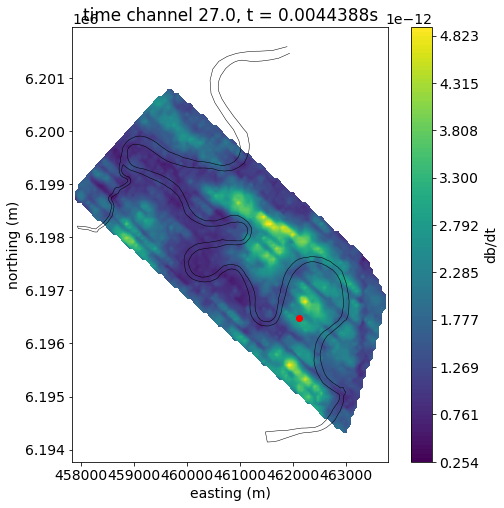

In [20]:
# plot the location
ax = plot_data(20)
ax.plot(easting[rxind], northing[rxind], 'ro')

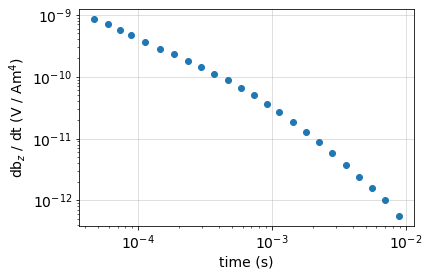

In [21]:
fig, ax = plt.subplots(1, 1)

ax.loglog(time_channels[:, 1], data[rxind, :], 'o')
ax.set_xlabel("time (s)")
ax.set_ylabel("db$_z$ / dt (V / Am$^4$)")
ax.grid("k", alpha=0.5)

In [22]:
data[rxind, :]

array([8.6834e-10, 7.1733e-10, 5.7363e-10, 4.6504e-10, 3.6778e-10,
       2.8449e-10, 2.2956e-10, 1.8119e-10, 1.4403e-10, 1.1223e-10,
       8.7201e-11, 6.6706e-11, 4.9847e-11, 3.6734e-11, 2.6492e-11,
       1.8701e-11, 1.2960e-11, 8.7210e-12, 5.7924e-12, 3.7382e-12,
       2.3747e-12, 1.5604e-12, 1.0100e-12, 5.5414e-13])

## set up the forward simulation

### Set up a mesh

- here, we use a cylindrically symmetric mesh to perform the 1D inversion
- we make sure that the forward simulation mesh extends beyond the diffusion distance of the latest time channel

$$
z_{max} = \sqrt{\frac{2 t}{\mu\sigma}} \approx 1260 \sqrt{\frac{ t}{\sigma}}
$$

- for more details on setting up a cylindrically symmetric mesh, see the [docs](http://docs.simpeg.xyz/content/api_core/api_MeshCode.html#cylindrical-mesh)

In [23]:
diffusion_distance = 1260 * np.sqrt(1e-2 / 1e-1)
print(diffusion_distance)

398.4469851812158


In [24]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
cs, ncx, ncz, npad = 1., 10., 10., 20
hx = [(cs, ncx), (cs, npad, 1.3)]
npad = 12

log_spaced_z_cells = np.logspace(np.log10(1.), np.log10(12.), 19)
z_padding = log_spaced_z_cells[-1] * 1.3 ** np.arange(npad)
hz = np.r_[z_padding[::-1], log_spaced_z_cells[::-1], log_spaced_z_cells, z_padding]
mesh = Mesh.CylMesh([hx, 1, hz], '00C')
active = mesh.vectorCCz < 0.

<AxesSubplot:xlabel='x', ylabel='z'>

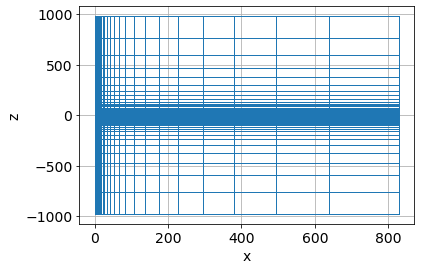

In [25]:
mesh.plotGrid()

### set up mappings and a starting model

Mappings are used in SimPEG to translate the set of parameters that we invert for to electrical conductivity values on the forward simulation mesh. 

Here, the inversion model is 1D log-conductivity below the surface. So we use an `InjectActiveCells` map to include the air cells, the `SurjectVertical1D` map to take the 1D model and put it on the cylindrically symmetric mesh, and the `ExpMap` to take the exponential of the log-conductivity values. 

In [26]:
sig_half = 1e-1
sig_air = 1e-8
active_inds = mesh.vectorCCz < 0.
active_map = Maps.InjectActiveCells(mesh, active_inds, np.log(sig_air), nC=mesh.nCz)
mapping = Maps.ExpMap(mesh) * Maps.SurjectVertical1D(mesh) * active_map

In [27]:
m0 = np.ones(active_inds.sum())*np.log(sig_half)

In [28]:
print(m0)

[-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509]


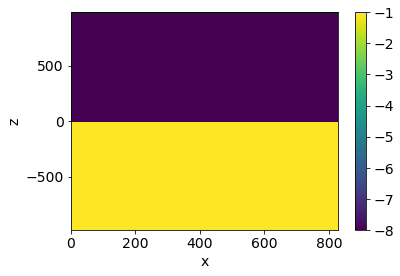

In [29]:
## plot the initial model

plt.colorbar(mesh.plotImage(np.log10(mapping*m0))[0])

### source waveform
- the below values were copied from the skytem header file for the high moment data
- we will need a finer discretization for the simulation, so we approximate it by the VTEM source function, which is very similar. 

In [30]:
waveform = np.vstack([
    np.r_[-10, -9.29, -8.41, -7.26, -5.28, -3.62, -2.33, -0.62, 0.00, 0.0266, 0.0276, 0.0286, 10.000]*1e-3,
    np.r_[0, 20, 40, 60, 80, 90, 95, 99, 100, 1.53, 0.566, 0.000, 0.000]/100.
]).T

In [31]:
t0 = -1*waveform[0, 0]
src_waveform = TDEM.Src.VTEMWaveform(a=3., peakTime=t0, offTime=t0+29e-6)

In [32]:
waveform[:, 0]+t0

array([0.       , 0.00071  , 0.00159  , 0.00274  , 0.00472  , 0.00638  ,
       0.00767  , 0.00938  , 0.01     , 0.0100266, 0.0100276, 0.0100286,
       0.02     ])

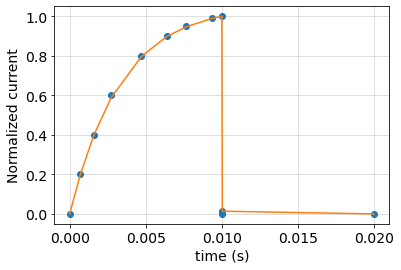

In [33]:
fig, ax = plt.subplots(1, 1)

ax.plot(waveform[:, 0]+t0, waveform[:, 1], 'o')
ax.plot(waveform[:, 0]+t0, [src_waveform.eval(t) for t in waveform[:, 0]+t0])
ax.set_xlabel("time (s)")
ax.set_ylabel("Normalized current")
ax.grid("k", alpha=0.5)

In [34]:
# loop parameters
area = 313.98
radius = np.sqrt(area/np.pi)
radius

9.997146496075098

In [35]:
# Bird height from the surface
system_height = elevation[rxind]
rxloc = np.array([[radius, 0., system_height]])
# The data are secondary field data
dbdtz = TDEM.Rx.Point_dbdt(
    rxloc,
    orientation='z',
    times=time_channels[:-3, 1] + t0
)

In [36]:
times = time_channels[:-3, 1] + t0
times

array([0.010047 , 0.0100598, 0.0100726, 0.0100886, 0.0101118, 0.0101454,
       0.0101852, 0.0102344, 0.0102952, 0.0103706, 0.0104644, 0.0105814,
       0.0107278, 0.0109112, 0.011117 , 0.0114292, 0.0117912, 0.012246 ,
       0.0128174, 0.0135356, 0.0144388])

In [37]:
# source
src_list = [
    TDEM.Src.CircularLoop(
        [dbdtz], loc=np.r_[0., 0., system_height], radius=radius,
        orientation='z',
        waveform=src_waveform, 
        current=1./area  # the data are normalized by loop area
    )
]

In [38]:
# solve the problem at these times
timeSteps = [
    (src_waveform.peakTime/3, 3), ((src_waveform.offTime-src_waveform.peakTime)/2, 2),
    (1e-5, 5), (5e-5, 5), (1e-4, 10), (5e-4, 15)
]
problem = TDEM.Problem3D_e(
    mesh, timeSteps=timeSteps, sigmaMap=mapping, Solver=Solver
)
survey = TDEM.Survey(src_list)
problem.pair(survey)

In [39]:
timeSteps

[(0.0033333333333333335, 3),
 (1.4499999999999756e-05, 2),
 (1e-05, 5),
 (5e-05, 5),
 (0.0001, 10),
 (0.0005, 15)]

In [40]:
waveform

array([[-1.00e-02,  0.00e+00],
       [-9.29e-03,  2.00e-01],
       [-8.41e-03,  4.00e-01],
       [-7.26e-03,  6.00e-01],
       [-5.28e-03,  8.00e-01],
       [-3.62e-03,  9.00e-01],
       [-2.33e-03,  9.50e-01],
       [-6.20e-04,  9.90e-01],
       [ 0.00e+00,  1.00e+00],
       [ 2.66e-05,  1.53e-02],
       [ 2.76e-05,  5.66e-03],
       [ 2.86e-05,  0.00e+00],
       [ 1.00e-02,  0.00e+00]])

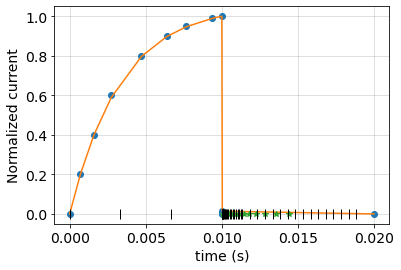

In [41]:
fig, ax = plt.subplots(1, 1)

ax.plot(waveform[:, 0]+t0, waveform[:, 1], 'o')
ax.plot(waveform[:, 0]+t0, [src_waveform.eval(t) for t in waveform[:, 0]+t0])
ax.plot(times,np.array(np.zeros(len(times))),'*')
ax.plot(problem.timeMesh.vectorNx, np.zeros(problem.timeMesh.nN), 'k|', ms=10)
ax.set_xlabel("time (s)")
ax.set_ylabel("Normalized current")
ax.grid("k", alpha=0.5)


### create data vector and run a forward simulation
- assign uncertainties to the data

In [42]:
std = 0.05
floor = 1e-12
dobs = data[rxind, :-3]  # ignore the last three time-channels
uncert = abs(dobs) * std + floor


In [43]:
np.save('dobs_3d',dobs)

run a forward simulation. 

This lets us sanity-check our setup. We don't expect the data to match, but should be similar in order-of-magnitude. 

In [44]:
%time
dpred_0 = survey.dpred(m0)

Wall time: 0 ns


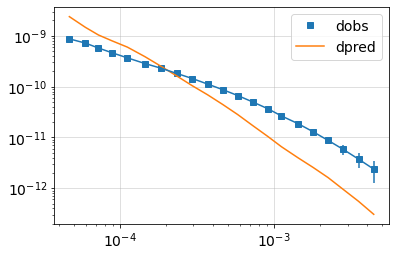

In [45]:
fig, ax = plt.subplots(1, 1)

ax.loglog(time_channels[:-3, 1], dobs, "C0s", label="dobs")
plt.errorbar(time_channels[:-3, 1], dobs, yerr=uncert, color="C0")
ax.loglog(time_channels[:-3, 1], -dpred_0, "C1", label="dpred")

ax.grid('k', alpha=0.5)
ax.legend()

In [48]:
dpred_0

array([-2.38084436e-09, -1.46303976e-09, -1.03624911e-09, -7.98974522e-10,
       -5.98481343e-10, -3.88091227e-10, -2.49853013e-10, -1.61287138e-10,
       -1.03780080e-10, -6.90270111e-11, -4.45358741e-11, -2.81547813e-11,
       -1.70822922e-11, -1.04543243e-11, -6.56280681e-12, -3.98619676e-12,
       -2.57170206e-12, -1.61586154e-12, -9.44280025e-13, -5.52698164e-13,
       -3.06285600e-13])

In [49]:
np.save('dpred_3d',dpred_0)

### Data uncertainties

In [50]:
survey.dobs = -dobs
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [51]:
survey.dobs

array([-8.6834e-10, -7.1733e-10, -5.7363e-10, -4.6504e-10, -3.6778e-10,
       -2.8449e-10, -2.2956e-10, -1.8119e-10, -1.4403e-10, -1.1223e-10,
       -8.7201e-11, -6.6706e-11, -4.9847e-11, -3.6734e-11, -2.6492e-11,
       -1.8701e-11, -1.2960e-11, -8.7210e-12, -5.7924e-12, -3.7382e-12,
       -2.3747e-12])

### Regularization

In [52]:
reg_mesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = Regularization.Tikhonov(reg_mesh, mapping=Maps.IdentityMap(reg_mesh))
reg.alpha_s = 1e-3
reg.alpha_x = 1.
reg.mref = m0.copy()

### State the inverse problem

For reference, see the [docs on inversion components](http://docs.simpeg.xyz/content/api_core/api_InversionComponents.html)

In [53]:
opt = Optimization.InexactGaussNewton(maxIter=10)
opt.LSshorten = 0.5
opt.remember('xc')

invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

In [54]:
target = Directives.TargetMisfit()  # stop when we hit target misfit
invProb.beta = 5.
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = Inversion.BaseInversion(invProb, directiveList=[target])
# run the inversion
mrec = inv.run(m0)



    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  1.40e+03  0.00e+00  1.40e+03    5.23e+02      0              
   1  5.00e+00  1.02e+02  5.66e-01  1.04e+02    8.41e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.4005e+02
0 : |xc-x_last| = 2.8262e+00 <= tolX*(1+|x0|) = 1.3820e+00
0 : |proj(x-g)-x|    = 8.4073e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 8.4073e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      2
------------------------- DONE! -------------------------


### plot the data

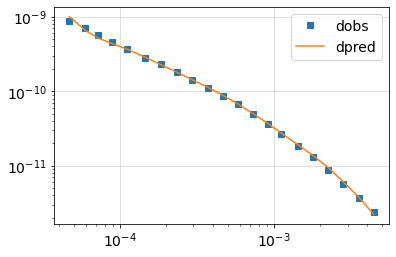

In [55]:
# extract the data so
dpred = invProb.dpred


fig, ax = plt.subplots(1, 1)

ax.loglog(time_channels[:-3, 1], dobs, "C0s", label="dobs")
ax.loglog(time_channels[:-3, 1], -dpred, "C1", label="dpred")

ax.grid('k', alpha=0.5)
ax.legend()

### Plot the recovered model

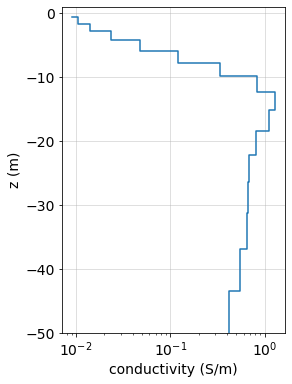

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

mplot = np.repeat(np.exp(mrec), 2, axis=0)
z = np.repeat(mesh.vectorCCz[active][1:], 2, axis=0)
ax.semilogx(mplot, np.r_[z[0], z, z[-1]])
ax.set_ylabel("z (m)")
ax.set_xlabel("conductivity (S/m)")
ax.set_ylim([-50, 1])
ax.grid('k', alpha=0.5)

In [57]:
m0.shape

(31,)

In [58]:
dobs.shape

(21,)